In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import tensorflow as tf
import numpy as np
import os
import importlib
import sys

from machine_learning.common import checks
from machine_learning.common import visualization
from machine_learning.common import datasets
from machine_learning.common import models
from machine_learning.common import error_analysis

import preprocessing

In [100]:
importlib.reload(checks)
importlib.reload(visualization)
importlib.reload(datasets)
importlib.reload(models)
importlib.reload(error_analysis)

importlib.reload(preprocessing)

<module 'preprocessing' from '/mnt/d/LinuxHome/repos/projects/machine_learning/kaggle_titanic/preprocessing.py'>

## Machine-Specific Configuration

The defaults are meant for my Windows WSL machine where I store datasets on my P drive and do not commit model checkpoints to GitHub.


In [5]:
INPUT_FOLDER = '/mnt/p/Datasets/titanic'  # This will be different on kaggle

TRAINING_DATA = os.path.join(INPUT_FOLDER, 'train.csv')
TEST_DATA = os.path.join(INPUT_FOLDER, 'test.csv')

MODEL_FOLDER = '/mnt/p/Models/kaggle-titanic'

## Sanity Checks

If any of these fail, you need to manually copy the files or fix a path above.


In [6]:
checks.check_condition(os.path.exists(TRAINING_DATA), 'Training file exists')
checks.check_condition(os.path.exists(TEST_DATA), 'Test file exists')

Training file exists: Pass
Test file exists: Pass


# Data Analysis


## Load Data


In [7]:
full_df = pd.read_csv(TRAINING_DATA, index_col="PassengerId")

## Examine Data


In [8]:
full_df

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S


In [9]:
full_df.dtypes

Survived      int64
Pclass        int64
Name         object
Sex          object
Age         float64
SibSp         int64
Parch         int64
Ticket       object
Fare        float64
Cabin        object
Embarked     object
dtype: object

The dataset does have some **skew** to it.


In [10]:
print(
    f'{100 * visualization.compute_truth_ratio(full_df, "Survived"):.2f}% survived'
)


38.38% survived


## Visualize Data

Because we have only a few columns, we can examine them individually to see which seem to help predict the survival rate.


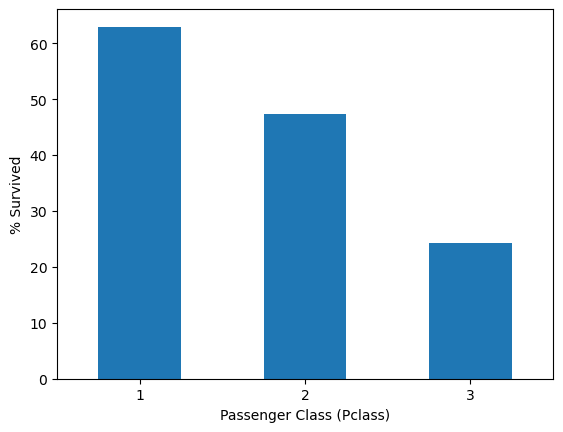

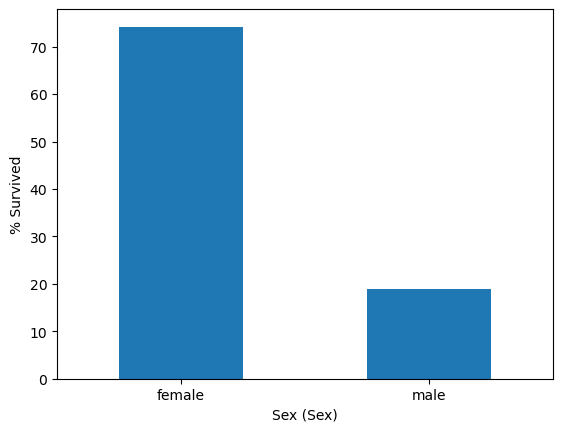

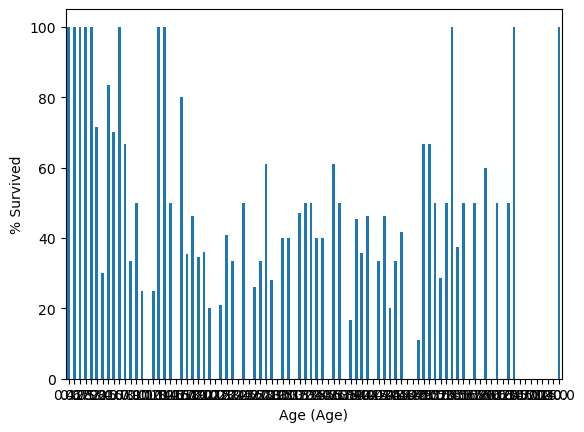

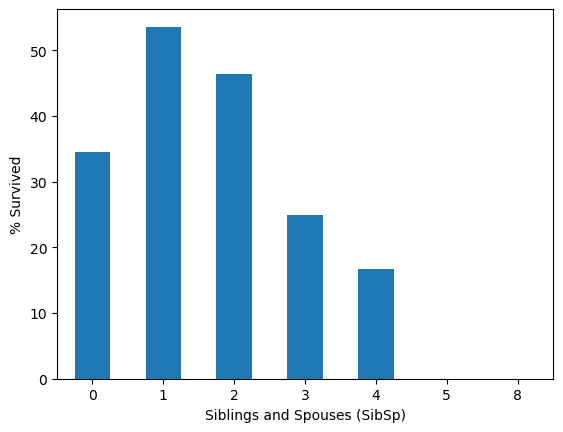

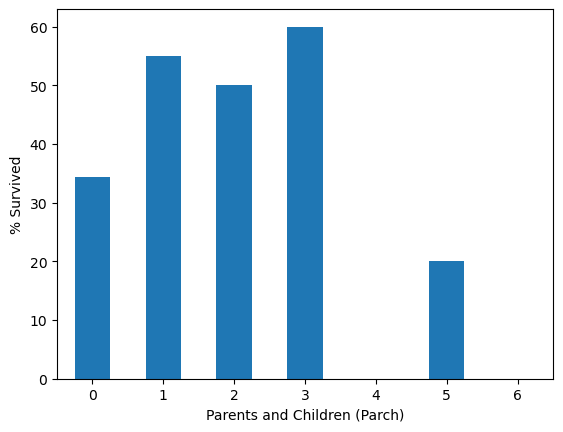

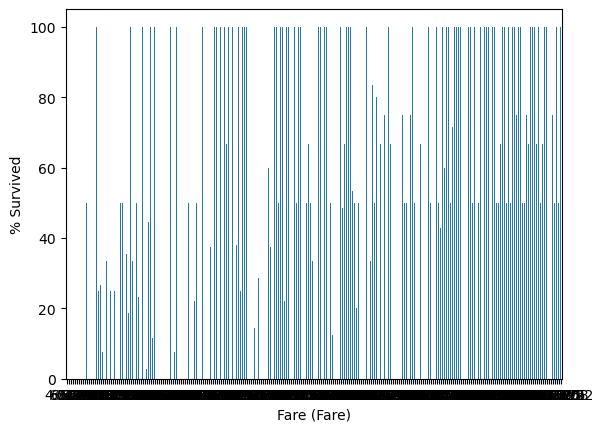

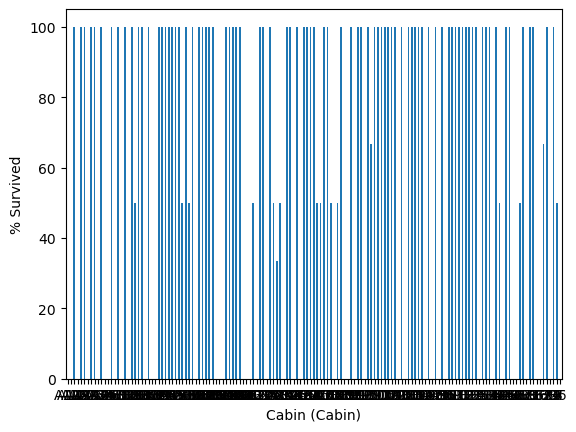

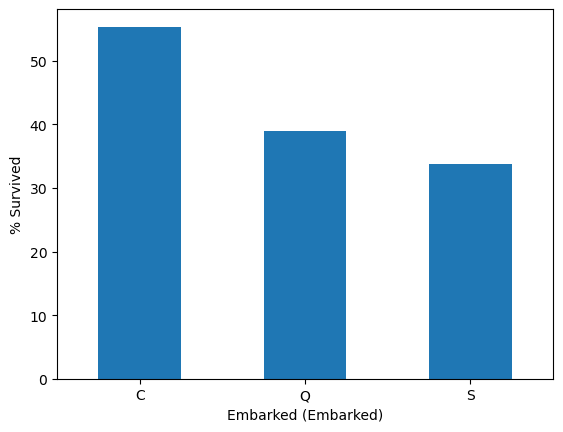

In [11]:
visualization.examine_candidate_column(full_df, 'Pclass', "Passenger Class",
                                       "Survived",
                                       "Survived")  # Looks very linear
visualization.examine_candidate_column(full_df, 'Sex', 'Sex', "Survived",
                                       "Survived")  # Looks very predictive
visualization.examine_candidate_column(
    full_df, 'Age', 'Age', "Survived",
    "Survived")  # Looks possibly useful but need to BUCKET
visualization.examine_candidate_column(
    full_df, 'SibSp', "Siblings and Spouses", "Survived",
    "Survived")  # It does look like 1-2 is a boost in survival rate
visualization.examine_candidate_column(
    full_df, 'Parch', "Parents and Children", "Survived",
    "Survived")  # Not clear that this is helpful
visualization.examine_candidate_column(
    full_df, 'Fare', 'Fare', "Survived",
    "Survived")  # Surprisingly unhelpful but maybe we can BUCKET it
visualization.examine_candidate_column(
    full_df, 'Cabin', 'Cabin', "Survived",
    "Survived")  # Surprisingly unhelpful but maybe we can BUCKET it
visualization.examine_candidate_column(
    full_df, 'Embarked', 'Embarked', "Survived", "Survived"
)  # Looks possibly helpful (exponential decay but with low resolution)


## Feature Engineering


Let's try age groups.


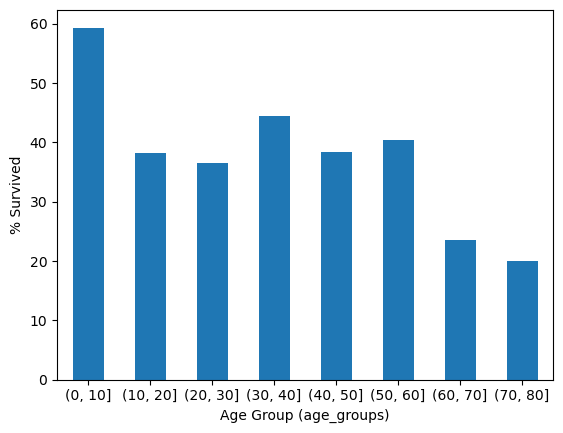

In [13]:
full_df['age_groups'] = pd.cut(full_df['Age'],
                               bins=range(
                                   0, int(math.floor(full_df['Age'].max() + 1)),
                                   10))
visualization.examine_candidate_column(full_df, 'age_groups', 'Age Group',
                                       "Survived", "Survived")


It makes a big difference how the fare groups are divided, but it seems like very high and very low fares may have been a disadvantage.


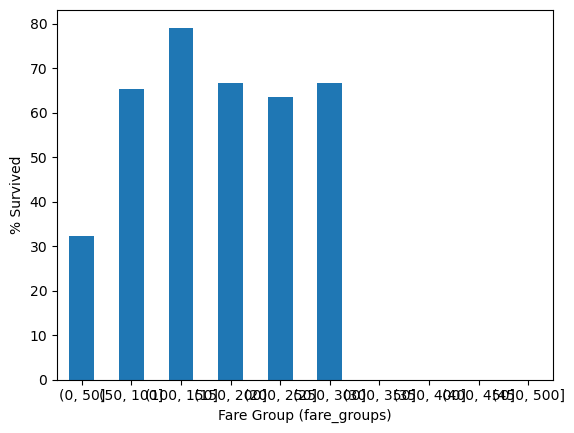

In [14]:
full_df['fare_groups'] = pd.cut(
    full_df['Fare'],
    bins=range(0, int(math.floor(full_df['Fare'].max() + 1)), 50))
visualization.examine_candidate_column(full_df, 'fare_groups', 'Fare Group',
                                       "Survived", "Survived")


## Column Selection


In [15]:
columns_to_use = [
    'Pclass', 'Sex', 'age_groups', 'fare_groups', 'SibSp', 'Embarked'
]
filtered_df = full_df[columns_to_use]
filtered_df

,Pclass,Sex,age_groups,fare_groups,SibSp,Embarked
PassengerId,,,,,,
1,3,male,"(20.0, 30.0]","(0, 50]",1,S
2,1,female,"(30.0, 40.0]","(50, 100]",1,C
3,3,female,"(20.0, 30.0]","(0, 50]",0,S
4,1,female,"(30.0, 40.0]","(50, 100]",1,S
5,3,male,"(30.0, 40.0]","(0, 50]",0,S
...,...,...,...,...,...,...
887,2,male,"(20.0, 30.0]","(0, 50]",0,S
888,1,female,"(10.0, 20.0]","(0, 50]",0,S
889,3,female,NaN,"(0, 50]",1,S


In [16]:
filtered_df.dtypes

Pclass            int64
Sex              object
age_groups     category
fare_groups    category
SibSp             int64
Embarked         object
dtype: object

In [17]:
full_df['Embarked'].unique()

array(['S', 'C', 'Q', nan], dtype=object)

## Column Formatting


In [18]:
filtered_df['Sex'] = (full_df['Sex'] == 'male').astype(int)
filtered_df['age_groups'] = full_df['age_groups'].cat.codes
filtered_df['fare_groups'] = full_df['fare_groups'].cat.codes
filtered_df['Embarked'] = pd.Categorical(
    full_df['Embarked'].fillna('NaN'),
    categories=full_df['Embarked'].fillna('NaN').unique()).codes
filtered_df


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

,Pclass,Sex,age_groups,fare_groups,SibSp,Embarked
PassengerId,,,,,,
1,3,1,2,0,1,0
2,1,0,3,1,1,1
3,3,0,2,0,0,0
4,1,0,3,1,1,0
5,3,1,3,0,0,0
...,...,...,...,...,...,...
887,2,1,2,0,0,0
888,1,0,1,0,0,0
889,3,0,-1,0,1,0


In [19]:
filtered_df.dtypes

Pclass         int64
Sex            int64
age_groups      int8
fare_groups     int8
SibSp          int64
Embarked        int8
dtype: object

# Input Pipeline

Having experimented with the data above, we can now set up the pipeline for our model based on what we found. Even though this dataset is small and I could just use the sklearn and pandas stuff above, I decided to do a full TF streamed pipeline for practice :-)

The file **preprocessing.py** was developed after doing the above analysis. Some of it duplicates what's up there, but it is meant to represent more of a production-ization of this project.


## Demonstration


In [20]:
datasets.show_first_batch(preprocessing.load_data())

2023-05-14 21:27:48.393317: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-14 21:27:48.415632: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-14 21:27:48.415697: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-14 21:27:48.422163: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-14 21:27:48.422237: I tensorflow/compile

---Features---
{'PassengerId': array([833, 843, 428, 194, 328, 335, 156, 148, 269, 737], dtype=int32), 'Pclass': array([3, 1, 2, 2, 2, 1, 1, 3, 1, 3], dtype=int32), 'Name': array([b'Saad, Mr. Amin', b'Serepeca, Miss. Augusta',
       b'Phillips, Miss. Kate Florence ("Mrs Kate Louise Phillips Marshall")',
       b'Navratil, Master. Michel M', b'Ball, Mrs. (Ada E Hall)',
       b'Frauenthal, Mrs. Henry William (Clara Heinsheimer)',
       b'Williams, Mr. Charles Duane',
       b'Ford, Miss. Robina Maggie "Ruby"',
       b'Graham, Mrs. William Thompson (Edith Junkins)',
       b'Ford, Mrs. Edward (Margaret Ann Watson)'], dtype=object), 'Sex': array([b'male', b'female', b'female', b'male', b'female', b'female',
       b'male', b'female', b'female', b'female'], dtype=object), 'Age': array([ 0., 30., 19.,  3., 36.,  0., 51.,  9., 58., 48.], dtype=float32), 'SibSp': array([0, 0, 0, 1, 0, 1, 0, 2, 0, 1], dtype=int32), 'Parch': array([0, 0, 0, 1, 0, 0, 1, 2, 1, 3], dtype=int32), 'Ticket': array

2023-05-14 21:27:51.008169: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]
2023-05-14 21:27:51.008669: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype string and shape [1]
	 [[{{node Placeholder/_11}}]]


In [21]:
datasets.show_first_batch(preprocessing.load_data().map(
    preprocessing.transform_columns))


---Features---
{'Class': array([3, 1, 2, 2, 2, 1, 1, 3, 1, 3], dtype=int32), 'Sex': array([1, 0, 0, 1, 0, 0, 1, 0, 0, 0], dtype=int32), 'Siblings': array([0, 0, 0, 1, 0, 1, 0, 2, 0, 1], dtype=int32), 'Origin': array([1, 1, 0, 0, 0, 0, 1, 0, 0, 0], dtype=int32), 'AgeGroup': array([0, 3, 1, 0, 3, 0, 5, 0, 5, 4], dtype=int32), 'FareGroup': array([0, 0, 0, 0, 0, 2, 1, 0, 3, 0], dtype=int32)}
---Labels---
[0 1 1 1 1 1 0 0 1 0]


2023-05-14 21:28:00.163620: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype string and shape [1]
	 [[{{node Placeholder/_11}}]]
2023-05-14 21:28:00.164189: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_15' with dtype string and shape [1]
	 [[{{node Placeholder/_15}}]]


In [22]:
datasets.show_first_batch(preprocessing.load_data()\
                              .map(preprocessing.transform_columns)\
                              .map(datasets.named_column_oh_expander(preprocessing.ONE_HOT_SPECS)))

---Features---
{'Class': array([3, 1, 2, 2, 2, 1, 1, 3, 1, 3], dtype=int32), 'Sex': array([[0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32), 'Siblings': array([0, 0, 0, 1, 0, 1, 0, 2, 0, 1], dtype=int32), 'Origin': array([[0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.]], dtype=float32), 'AgeGroup': array([0, 3, 1, 0, 3, 0, 5, 0, 5, 4], dtype=int32), 'FareGroup': array([0, 0, 0, 0, 0, 2, 1, 0, 3, 0], dtype=int32)}
---Labels---
[0 1 1 1 1 1 0 0 1 0]


2023-05-14 21:28:07.150469: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32 and shape [1]
	 [[{{node Placeholder/_14}}]]
2023-05-14 21:28:07.151015: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype string and shape [1]
	 [[{{node Placeholder/_10}}]]


In [23]:
dataset = preprocessing.load_data()\
                .map(preprocessing.transform_columns)\
                .map(datasets.named_column_oh_expander(preprocessing.ONE_HOT_SPECS))\
                .map(datasets.to_matrix())
datasets.show_first_batch(dataset)

---Features---
[[3. 0. 1. 0. 0. 1. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 1. 0. 0. 3. 0.]
 [2. 1. 0. 0. 1. 0. 0. 0. 1. 0.]
 [2. 0. 1. 1. 1. 0. 0. 0. 0. 0.]
 [2. 1. 0. 0. 1. 0. 0. 0. 3. 0.]
 [1. 1. 0. 1. 1. 0. 0. 0. 0. 2.]
 [1. 0. 1. 0. 0. 1. 0. 0. 5. 1.]
 [3. 1. 0. 2. 1. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 1. 0. 0. 0. 5. 3.]
 [3. 1. 0. 1. 1. 0. 0. 0. 4. 0.]]
---Labels---
[0 1 1 1 1 1 0 0 1 0]


2023-05-14 21:28:07.883956: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_12' with dtype float and shape [1]
	 [[{{node Placeholder/_12}}]]
2023-05-14 21:28:07.884466: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype string and shape [1]
	 [[{{node Placeholder/_11}}]]


In [24]:
temp_train, temp_val = (datasets.split(
    preprocessing.load_data(batch_size=10).map(preprocessing.transform_columns),
    num_batches=preprocessing.DATASET_SIZE / 10))

datasets.show_first_batch(temp_train)
print(f'Training Batches: {datasets.count_batches(temp_train)}')
print()
datasets.show_first_batch(temp_val)
print(f'Validation Batches: {datasets.count_batches(temp_val)}')

2023-05-14 21:28:08.424117: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]
2023-05-14 21:28:08.424678: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_12' with dtype float and shape [1]
	 [[{{node Placeholder/_12}}]]
2023-05-14 21:28:08.497586: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{

---Features---
{'Class': array([3, 1, 2, 2, 2, 1, 1, 3, 1, 3], dtype=int32), 'Sex': array([1, 0, 0, 1, 0, 0, 1, 0, 0, 0], dtype=int32), 'Siblings': array([0, 0, 0, 1, 0, 1, 0, 2, 0, 1], dtype=int32), 'Origin': array([1, 1, 0, 0, 0, 0, 1, 0, 0, 0], dtype=int32), 'AgeGroup': array([0, 3, 1, 0, 3, 0, 5, 0, 5, 4], dtype=int32), 'FareGroup': array([0, 0, 0, 0, 0, 2, 1, 0, 3, 0], dtype=int32)}
---Labels---
[0 1 1 1 1 1 0 0 1 0]
Training Batches: 71

---Features---
{'Class': array([1, 2, 3, 1, 1, 2, 3, 3, 2, 3], dtype=int32), 'Sex': array([1, 0, 1, 1, 1, 1, 1, 1, 0, 0], dtype=int32), 'Siblings': array([0, 1, 1, 1, 0, 0, 0, 0, 0, 0], dtype=int32), 'Origin': array([0, 0, 1, 1, 1, 0, 0, 0, 0, 2], dtype=int32), 'AgeGroup': array([8, 4, 0, 4, 5, 0, 1, 2, 5, 0], dtype=int32), 'FareGroup': array([0, 0, 0, 1, 2, 0, 0, 0, 0, 0], dtype=int32)}
---Labels---
[1 0 1 1 0 0 1 0 1 1]
Validation Batches: 19


2023-05-14 21:28:08.663583: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_17' with dtype string and shape [1]
	 [[{{node Placeholder/_17}}]]
2023-05-14 21:28:08.664177: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]


## Training: Feature Scalers

Run this cell to create the scalers file on disk to be used for feature scaling in the actual model.

Used default training/validation split and only trained based on the train part because using the validation seems like cheating.


In [25]:
scalers = datasets.create_named_scalers(preprocessing.SCALED_COLUMNS)
datasets.train_named_scalers(scalers,
                             datasets.split(preprocessing.load_data(batch_size=preprocessing.BIGGER_BATCH_SIZE)\
                                                         .map(preprocessing.transform_columns),
                                            num_batches=preprocessing.DATASET_SIZE / preprocessing.BIGGER_BATCH_SIZE)[0])
preprocessing.save_scalers(scalers)
scalers = preprocessing.load_scalers()  # Pretend this is a different session

for column in scalers:
    print(
        f'{column}: mean={scalers[column].mean_}, std={math.sqrt(scalers[column].var_)}'
    )

print()
datasets.show_first_batch(preprocessing.load_data().map(
    preprocessing.transform_columns).map(datasets.named_column_scaler(scalers)))


2023-05-14 21:28:12.926466: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_13' with dtype int32 and shape [1]
	 [[{{node Placeholder/_13}}]]
2023-05-14 21:28:12.927034: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_18' with dtype string and shape [1]
	 [[{{node Placeholder/_18}}]]


Class: mean=[2.31], std=0.834719799008711
Siblings: mean=[0.52428571], std=1.1430455201891523
AgeGroup: mean=[2.01571429], std=1.689812814171669
FareGroup: mean=[0.28285714], std=0.8783054184981813

---Features---
{'Class': array([ 0.8266247 , -1.56938892, -0.37138211, -0.37138211, -0.37138211,
       -1.56938892, -1.56938892,  0.8266247 , -1.56938892,  0.8266247 ]), 'Sex': array([1, 0, 0, 1, 0, 0, 1, 0, 0, 0], dtype=int32), 'Siblings': array([-0.4586744, -0.4586744, -0.4586744,  0.4161814, -0.4586744,
        0.4161814, -0.4586744,  1.2910372, -0.4586744,  0.4161814]), 'Origin': array([1, 1, 0, 0, 0, 0, 1, 0, 0, 0], dtype=int32), 'AgeGroup': array([-1.19286247,  0.5824821 , -0.60108095, -1.19286247,  0.5824821 ,
       -1.19286247,  1.76604514, -1.19286247,  1.76604514,  1.17426362]), 'FareGroup': array([-0.32204873, -0.32204873, -0.32204873, -0.32204873, -0.32204873,
        1.95506349,  0.81650738, -0.32204873,  3.0936196 , -0.32204873])}
---Labels---
[0 1 1 1 1 1 0 0 1 0]


2023-05-14 21:28:13.145084: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_18' with dtype string and shape [1]
	 [[{{node Placeholder/_18}}]]
2023-05-14 21:28:13.145680: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]


# Deep Learning


Unlike the general approach above, the cells in this section are meant to all be run in order instead of cherrypicked.


## Hyperparameters


In [109]:
LAYER_UNITS = [100] * 14 + [1]
LEARNING_RATE = 0.00005
EPOCHS = 70
BATCH_SIZE = 64
FILE_MODS = ''

## Load the datasets for real.


In [110]:
training_data, validation_data = preprocessing.prepare_training_data_for_model(
    batch_size=BATCH_SIZE)
print('Training Batches: ' + str(datasets.count_batches(training_data).numpy()))
print('Validation Bathces: ' +
      str(datasets.count_batches(validation_data).numpy()))


2023-05-18 23:42:14.157766: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]
2023-05-18 23:42:14.158569: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_12' with dtype float and shape [1]
	 [[{{node Placeholder/_12}}]]
2023-05-18 23:42:14.299645: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype string and shape [1]
	 [[{

Training Batches: 11
Validation Bathces: 3


## Create the Model

It might be beneficial to check **F1 score** as well, but since the competition uses accuracy, I won't bother here. It's a little bit skewed (67% death rate), but not too horrible.


In [111]:
model = models.create_basic_ffn(LAYER_UNITS)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
              loss='binary_crossentropy',
              metrics=['accuracy'])


## Train the Model


In [112]:
%time history = model.fit(training_data, epochs=EPOCHS, validation_data=validation_data)

Epoch 1/70


2023-05-18 23:42:21.181303: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_12' with dtype float and shape [1]
	 [[{{node Placeholder/_12}}]]
2023-05-18 23:42:21.182204: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_13' with dtype int32 and shape [1]
	 [[{{node Placeholder/_13}}]]


      9/Unknown - 4s 25ms/step - loss: 0.6929 - accuracy: 0.5434

2023-05-18 23:42:25.079899: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_17' with dtype string and shape [1]
	 [[{{node Placeholder/_17}}]]
2023-05-18 23:42:25.080496: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_15' with dtype string and shape [1]
	 [[{{node Placeholder/_15}}]]


11/11 [==============================] - 4s 57ms/step - loss: 0.6928 - accuracy: 0.5625 - val_loss: 0.6924 - val_accuracy: 0.5936
Epoch 2/70
11/11 [==============================] - 0s 39ms/step - loss: 0.6916 - accuracy: 0.6321 - val_loss: 0.6909 - val_accuracy: 0.6417
Epoch 3/70
11/11 [==============================] - 0s 29ms/step - loss: 0.6903 - accuracy: 0.6321 - val_loss: 0.6891 - val_accuracy: 0.6524
Epoch 4/70
11/11 [==============================] - 0s 29ms/step - loss: 0.6887 - accuracy: 0.6321 - val_loss: 0.6864 - val_accuracy: 0.6684
Epoch 5/70
11/11 [==============================] - 0s 31ms/step - loss: 0.6864 - accuracy: 0.6321 - val_loss: 0.6837 - val_accuracy: 0.6631
Epoch 6/70
11/11 [==============================] - 0s 30ms/step - loss: 0.6817 - accuracy: 0.6719 - val_loss: 0.6769 - val_accuracy: 0.7112
Epoch 7/70
11/11 [==============================] - 0s 35ms/step - loss: 0.6771 - accuracy: 0.6804 - val_loss: 0.6716 - val_accuracy: 0.6952
Epoch 8/70
11/11 [======

Epoch 59/70
11/11 [==============================] - 0s 31ms/step - loss: 0.3766 - accuracy: 0.8381 - val_loss: 0.3648 - val_accuracy: 0.8396
Epoch 60/70
11/11 [==============================] - 0s 33ms/step - loss: 0.3634 - accuracy: 0.8423 - val_loss: 0.3666 - val_accuracy: 0.8396
Epoch 61/70
11/11 [==============================] - 0s 32ms/step - loss: 0.3641 - accuracy: 0.8452 - val_loss: 0.3633 - val_accuracy: 0.8396
Epoch 62/70
11/11 [==============================] - 0s 33ms/step - loss: 0.3682 - accuracy: 0.8438 - val_loss: 0.4232 - val_accuracy: 0.8289
Epoch 63/70
11/11 [==============================] - 0s 30ms/step - loss: 0.3737 - accuracy: 0.8409 - val_loss: 0.3902 - val_accuracy: 0.8449
Epoch 64/70
11/11 [==============================] - 0s 30ms/step - loss: 0.3614 - accuracy: 0.8537 - val_loss: 0.3332 - val_accuracy: 0.8663
Epoch 65/70
11/11 [==============================] - 0s 30ms/step - loss: 0.3836 - accuracy: 0.8409 - val_loss: 0.3973 - val_accuracy: 0.8289
Epoch 

## Save the checkpoint

For now I will just be saving the final training result (instead of using a callback) and using the SavedModel format so that the model can be loaded without rebuilding the architecture.


In [113]:
layer_units_chunk = ','.join([str(unit) for unit in LAYER_UNITS])
hyperparameters = [
    layer_units_chunk, LEARNING_RATE, EPOCHS, BATCH_SIZE, FILE_MODS
]
checkpoint_chunks = [str(hyperparameter) for hyperparameter in hyperparameters]
checkpoint_name = '_'.join(checkpoint_chunks)
checkpoint_path = os.path.join(MODEL_FOLDER, checkpoint_name)

model.save(checkpoint_path
          )  # automatically overwrites and uses SavedModel format w/ optimizer

os.path.exists(
    checkpoint_path
)  # This is a folder containing a bunch of stuff inside (not a single file)


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 100), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fc29c47a4d0>, 140470535167056), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 100), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fc29c47a4d0>, 140470535167056), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(100,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fc1d85711d0>, 140470535174176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(100,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fc1d85711d0>, 140470535174176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(100, 100), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fc34695f510>, 140470535243136), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(100, 100), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fc34695f510>, 140470535243136), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(100,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fc2e07de9d0>, 140470535242016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(100,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fc2e07de9d0>, 140470535242016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(100, 100), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fc1d8287050>, 140470535249456), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(100, 100), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fc1d8287050>, 140470535249456), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(100,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fc2187e6c50>, 140470535244016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(100,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fc2187e6c50>, 140470535244016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(100, 100), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fc2e07a36d0>, 140474355644208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(100, 100), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fc2e07a36d0>, 140474355644208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(100,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fc1f815fbd0>, 140474355634688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(100,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fc1f815fbd0>, 140474355634688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(100, 100), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fc1f839bad0>, 140470535183760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(100, 100), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fc1f839bad0>, 140470535183760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(100,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fc2181acc10>, 140470535192320), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(100,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fc2181acc10>, 140470535192320), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(100, 100), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fc1f840f510>, 140470535251056), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(100, 100), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fc1f840f510>, 140470535251056), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(100,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fc2187bf890>, 140470535241856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(100,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fc2187bf890>, 140470535241856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(100, 100), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fc29c4c25d0>, 140474355826192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(100, 100), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fc29c4c25d0>, 140474355826192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(100,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fc1d87baf90>, 140474355813072), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(100,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fc1d87baf90>, 140474355813072), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(100, 100), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fc1d86ee210>, 140471607537344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(100, 100), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fc1d86ee210>, 140471607537344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(100,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fc218393090>, 140471607536064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(100,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fc218393090>, 140471607536064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(100, 100), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fc218343b10>, 140474355826352), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(100, 100), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fc218343b10>, 140474355826352), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(100,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fc21878e990>, 140474355826512), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(100,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fc21878e990>, 140474355826512), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(100, 100), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fc21878e150>, 140474355634608), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(100, 100), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fc21878e150>, 140474355634608), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(100,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fc1d8291c90>, 140474355633888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(100,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fc1d8291c90>, 140474355633888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(100, 100), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fc1d828c1d0>, 140471607534384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(100, 100), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fc1d828c1d0>, 140471607534384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(100,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fc1d82719d0>, 140471607537504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(100,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fc1d82719d0>, 140471607537504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(100, 100), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fc2786dd3d0>, 140471607539984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(100, 100), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fc2786dd3d0>, 140471607539984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(100,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fc2786de150>, 140471607536304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(100,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fc2786de150>, 140471607536304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(100, 100), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fc29c5282d0>, 140470535253616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(100, 100), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fc29c5282d0>, 140470535253616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(100,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fc1f8784250>, 140474355643808), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(100,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fc1f8784250>, 140474355643808), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(100, 100), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fc33ff09710>, 140471607529744), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(100, 100), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fc33ff09710>, 140471607529744), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(100,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fc29c576f50>, 140471607533424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(100,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fc29c576f50>, 140471607533424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(100, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fc21830cb10>, 140471607537664), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(100, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fc21830cb10>, 140471607537664), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fc1d84fc550>, 140471607535984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fc1d84fc550>, 140471607535984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 100), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fc29c47a4d0>, 140470535167056), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 100), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fc29c47a4d0>, 140470535167056), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(100,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fc1d85711d0>, 140470535174176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(100,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fc1d85711d0>, 140470535174176), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(100, 100), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fc34695f510>, 140470535243136), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(100, 100), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fc34695f510>, 140470535243136), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(100,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fc2e07de9d0>, 140470535242016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(100,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fc2e07de9d0>, 140470535242016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(100, 100), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fc1d8287050>, 140470535249456), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(100, 100), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fc1d8287050>, 140470535249456), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(100,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fc2187e6c50>, 140470535244016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(100,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fc2187e6c50>, 140470535244016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(100, 100), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fc2e07a36d0>, 140474355644208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(100, 100), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fc2e07a36d0>, 140474355644208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(100,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fc1f815fbd0>, 140474355634688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(100,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fc1f815fbd0>, 140474355634688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(100, 100), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fc1f839bad0>, 140470535183760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(100, 100), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fc1f839bad0>, 140470535183760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(100,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fc2181acc10>, 140470535192320), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(100,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fc2181acc10>, 140470535192320), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(100, 100), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fc1f840f510>, 140470535251056), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(100, 100), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fc1f840f510>, 140470535251056), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(100,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fc2187bf890>, 140470535241856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(100,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fc2187bf890>, 140470535241856), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(100, 100), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fc29c4c25d0>, 140474355826192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(100, 100), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fc29c4c25d0>, 140474355826192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(100,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fc1d87baf90>, 140474355813072), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(100,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fc1d87baf90>, 140474355813072), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(100, 100), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fc1d86ee210>, 140471607537344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(100, 100), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fc1d86ee210>, 140471607537344), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(100,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fc218393090>, 140471607536064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(100,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fc218393090>, 140471607536064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(100, 100), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fc218343b10>, 140474355826352), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(100, 100), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fc218343b10>, 140474355826352), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(100,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fc21878e990>, 140474355826512), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(100,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fc21878e990>, 140474355826512), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(100, 100), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fc21878e150>, 140474355634608), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(100, 100), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fc21878e150>, 140474355634608), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(100,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fc1d8291c90>, 140474355633888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(100,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fc1d8291c90>, 140474355633888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(100, 100), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fc1d828c1d0>, 140471607534384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(100, 100), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fc1d828c1d0>, 140471607534384), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(100,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fc1d82719d0>, 140471607537504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(100,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fc1d82719d0>, 140471607537504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(100, 100), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fc2786dd3d0>, 140471607539984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(100, 100), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fc2786dd3d0>, 140471607539984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(100,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fc2786de150>, 140471607536304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(100,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fc2786de150>, 140471607536304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(100, 100), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fc29c5282d0>, 140470535253616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(100, 100), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fc29c5282d0>, 140470535253616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(100,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fc1f8784250>, 140474355643808), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(100,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fc1f8784250>, 140474355643808), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(100, 100), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fc33ff09710>, 140471607529744), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(100, 100), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fc33ff09710>, 140471607529744), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(100,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fc29c576f50>, 140471607533424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(100,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fc29c576f50>, 140471607533424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(100, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fc21830cb10>, 140471607537664), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(100, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fc21830cb10>, 140471607537664), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fc1d84fc550>, 140471607535984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fc1d84fc550>, 140471607535984), {}).


INFO:tensorflow:Assets written to: /mnt/p/Models/kaggle-titanic/100,100,100,100,100,100,100,100,100,100,100,100,100,100,1_5e-05_70_64_/assets


INFO:tensorflow:Assets written to: /mnt/p/Models/kaggle-titanic/100,100,100,100,100,100,100,100,100,100,100,100,100,100,1_5e-05_70_64_/assets


True

## Analyze the Learning Curve


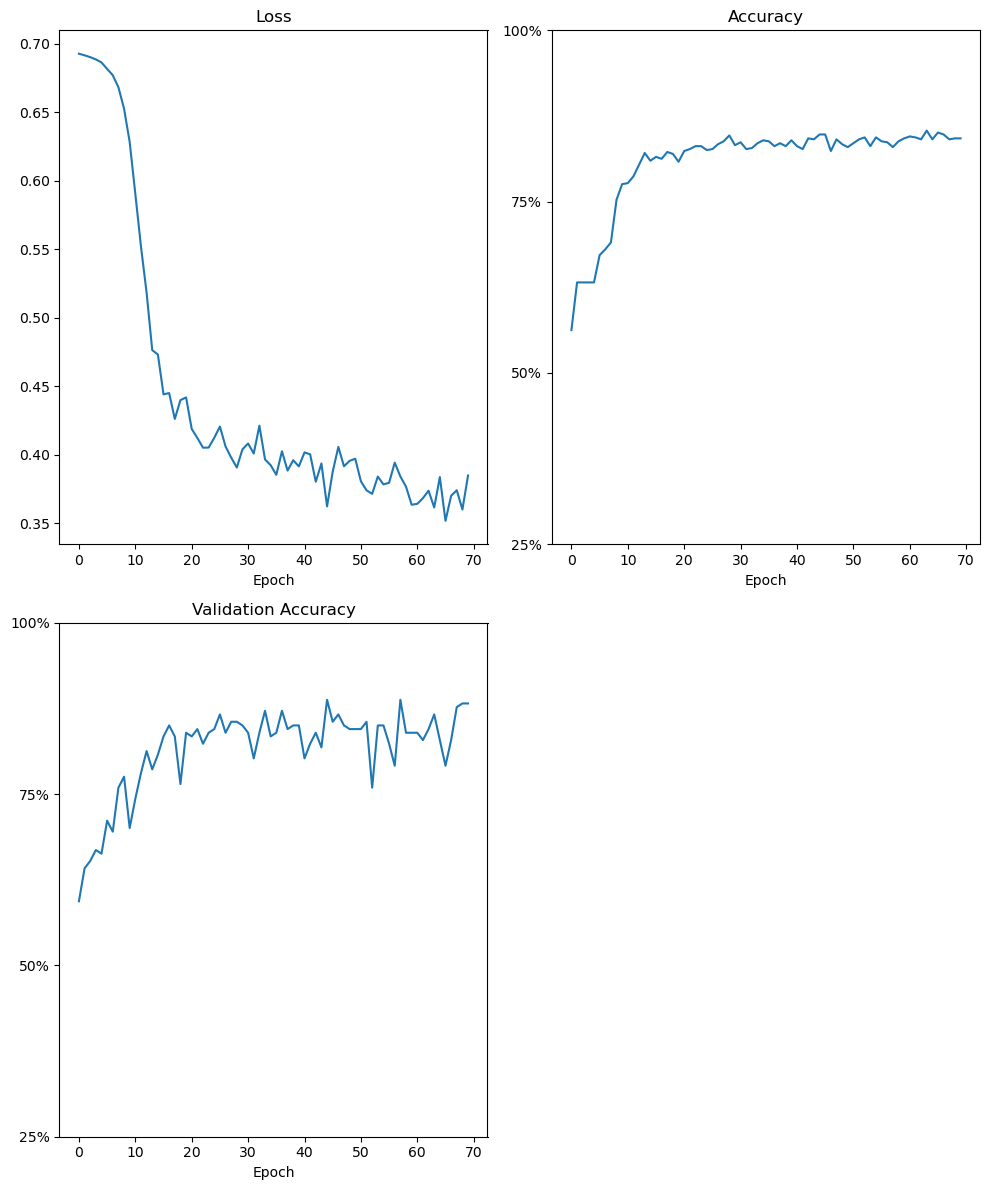

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_216 (Dense)           (None, 100)               1100      
                                                                 
 dense_217 (Dense)           (None, 100)               10100     
                                                                 
 dense_218 (Dense)           (None, 100)               10100     
                                                                 
 dense_219 (Dense)           (None, 100)               10100     
                                                                 
 dense_220 (Dense)           (None, 100)               10100     
                                                                 
 dense_221 (Dense)           (None, 100)               10100     
                                                                 
 dense_222 (Dense)           (None, 100)             

In [114]:
visualization.graph_training_stats(history)
model.summary()

## Aggregate Stats for Model Selection

Rather than show all the plots and stats in this notebook for all the models I tried, I'm just going to hardcode a table. Also, if I go in one direction (eg. try changing the batch size) and it performs worse than the best, I will tend to try other things to fix it or make it better than the best so far - I don't spend the time to document all the combinations here.

Note that the first row is entirely equivalent to **logistic regression**.

Also, only training runs that looked to be leveling off at the end are included. If not, then I added epochs and tried again. If the graph shows I included too many epochs, I do it again with just enough so that things are better comparable.

With the larger batch sizes, validation accuracy became extremely noisy, so even though the larger batch sizes appear to have much larger validation accuracies, it's not gauranteed this will generalize well to the test set.

Removing origin and fare group seemed to slightly hurt all architectures.


| Architecture  | Learning Rate | Batch Size | Epochs |     | Training Accuracy (%) | Validation Accuracy (%) | Wall Time (s) |
| :-----------: | :-----------: | :--------: | :----: | :-: | :-------------------: | :---------------------: | :-----------: |
|     _[1]_     |    _0.001_    |    _32_    | _120_  |  -  |         81.8%         |          82.9%          |     43.4      |
|    _[5,1]_    |    _0.001_    |    _32_    |  _50_  |  -  |         80.0%         |          76.5%          |     19.8      |
|   _[5,5,1]_   |    _0.001_    |    _32_    |  _40_  |  -  |         83.4%         |          77.5%          |     17.1      |
|  _[10,5,1]_   |    _0.001_    |    _32_    |  _40_  |  -  |         82.5%         |          78.6%          |     17.0      |
| _[100,100,1]_ |    _0.001_    |    _32_    |  _40_  |  -  |         85.5%         |          78.6%          |     16.3      |
|     _[1]_     |    _0.010_    |   _100_    |  _25_  |  -  |         80.0%         |          85.9%          |      7.4      |
|   _[5,5,1]_   |    _0.010_    |   _100_    |  _20_  |  -  |         83.1%         |          85.9%          |      6.6      |
|  _[100x9,1]_  |   _0.0001_    |    _32_    |  _50_  |  -  |         84.1%         |          81.3%          |     27.0      |
| _[100x14,1]_  |   _0.00005_   |    _64_    |  _70_  |  -  |         84.1%         |          90.4%          |     27.0      |

I tried models with more layers than listed here and the results were about the same and then eventually got worse.


## Trying Dropout and BatchNorm

This does not appear to have helped in this case.


Epoch 1/100
22/22 [==============================] - 2s 28ms/step - loss: 0.7703 - accuracy: 0.5142 - val_loss: 0.6437 - val_accuracy: 0.6043
Epoch 2/100
22/22 [==============================] - 1s 25ms/step - loss: 0.6862 - accuracy: 0.5966 - val_loss: 0.6170 - val_accuracy: 0.6471
Epoch 3/100
22/22 [==============================] - 0s 17ms/step - loss: 0.6474 - accuracy: 0.6307 - val_loss: 0.6365 - val_accuracy: 0.5936
Epoch 4/100
22/22 [==============================] - 0s 17ms/step - loss: 0.6488 - accuracy: 0.6278 - val_loss: 0.5966 - val_accuracy: 0.6310
Epoch 5/100
22/22 [==============================] - 0s 17ms/step - loss: 0.6419 - accuracy: 0.6307 - val_loss: 0.6041 - val_accuracy: 0.6096
Epoch 6/100
22/22 [==============================] - 0s 18ms/step - loss: 0.6053 - accuracy: 0.6960 - val_loss: 0.5788 - val_accuracy: 0.7807
Epoch 7/100
22/22 [==============================] - 0s 20ms/step - loss: 0.6050 - accuracy: 0.6946 - val_loss: 0.5423 - val_accuracy: 0.7807
Epoch 

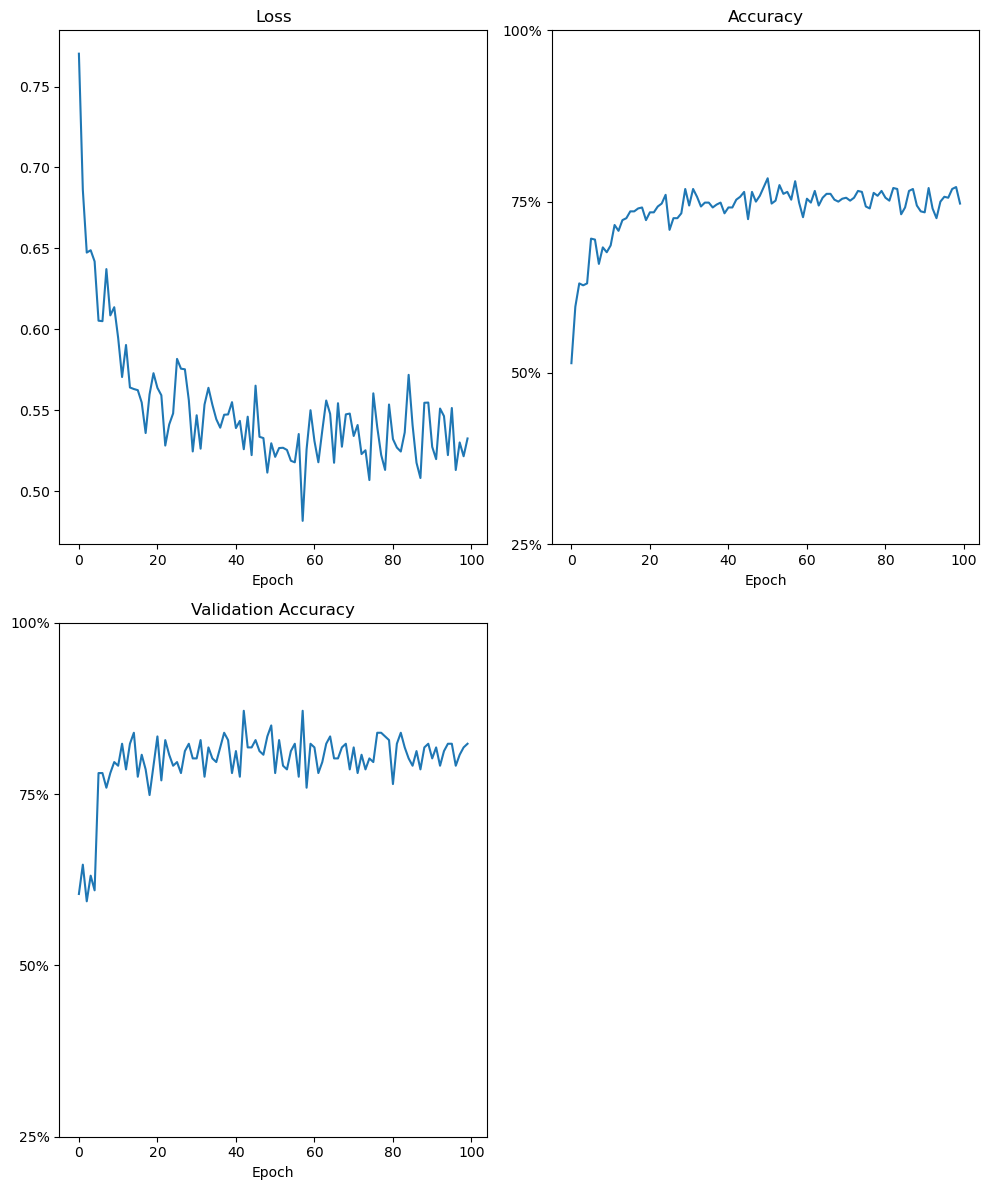

In [265]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(5),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Activation('relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(5),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Activation('relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])
%time history = model.fit(training_data, epochs=100, validation_data=validation_data)
visualization.graph_training_stats(history)

## Error Analysis

Before running this cell, you should run the following cells:

- hyperparameters (the actual values don't matter)
- loading data for real

You should also set the checkpoint below.

Two weird things I found out while trying to get this to work:

- If you use any other load call other than tf.keras.models.load_model, all the keras stuff like model.fit is missing. See https://github.com/tensorflow/models/issues/8990#issuecomment-1069733488
- Your checkpoint name cannot have [] in the name - that will cause it to parse wrong and claim the variables/variables folder doesn't exist even though you can plainly see it there.

Observations from analyzing some checkpoints:

- Logistic Regression
  - True positives are almost entirely female and true negatives are almost entirely male while false negatives are almost entirely male and false positives are leaning female but not as hard leaning as the other 3 quadrants. Since my accuracy in the competition data ends up aligning closely with the gender guess results, my model may be overemphasizing the gender aspect.
  - Origin doesn't look that different between the 4 quadrants - maybe it's not that important
  - Fare Group also doesn't look that different between the 4 quadrants - maybe it's not that important
  - Ideas to Improve:

    - increase the complexity of the model
    - drop fare group
    - drop origin
    - use full training+validation set since already small and noisy
- Deeper Models
  - Same overall characteristics described above


In [16]:
CHECKPOINT_TO_ANALYZE = '1_0.001_120_32_'

model = tf.keras.models.load_model(
    os.path.join(MODEL_FOLDER, CHECKPOINT_TO_ANALYZE))

# If you didn't want to load the whole dataset into memory, you could do this in batches with model.predict_on_batch.
validation_input_tensor, validation_label_tensor = datasets.collect_tensors(
    validation_data)
validation_output_tensor = tf.cast(
    model.predict(validation_input_tensor) >= 0.5, tf.int32)

error_analysis_matrices = error_analysis.compute_error_analysis_matrices(
    validation_input_tensor, validation_label_tensor, validation_output_tensor)
error_analysis.print_error_analysis_matrices(error_analysis_matrices)

6/6 [==============================] - 0s 1ms/step
[true_positives]
Shape: (52, 10)

-0.37138212	1.0	0.0	0.41618142	1.0	0.0	0.0	0.0	-0.009299424	-0.32204872	
-0.37138212	1.0	0.0	0.41618142	0.0	1.0	0.0	0.0	-1.1928625	-0.32204872	
-0.37138212	1.0	0.0	-0.4586744	0.0	1.0	0.0	0.0	-0.60108095	-0.32204872	
-1.5693889	1.0	0.0	1.2910372	1.0	0.0	0.0	0.0	1.7660451	0.8165074	
-1.5693889	1.0	0.0	-0.4586744	0.0	1.0	0.0	0.0	0.5824821	1.9550635	
-1.5693889	1.0	0.0	0.41618142	1.0	0.0	0.0	0.0	1.7660451	0.8165074	
-0.37138212	1.0	0.0	0.41618142	1.0	0.0	0.0	0.0	-0.009299424	-0.32204872	
-1.5693889	1.0	0.0	-0.4586744	0.0	1.0	0.0	0.0	-1.1928625	0.8165074	
0.8266247	1.0	0.0	1.2910372	0.0	1.0	0.0	0.0	-1.1928625	-0.32204872	
-1.5693889	1.0	0.0	-0.4586744	0.0	1.0	0.0	0.0	1.7660451	0.8165074	
-1.5693889	1.0	0.0	-0.4586744	1.0	0.0	0.0	0.0	0.5824821	0.8165074	
-0.37138212	1.0	0.0	-0.4586744	1.0	0.0	0.0	0.0	-0.60108095	-0.32204872	
-0.37138212	1.0	0.0	0.41618142	1.0	0.0	0.0	0.0	-1.1928625	-0.32204872	
0.8266247	1.0

## Model Selection

After trying dropping Origin and/or Fare Group, I found that the performance did not improve, and the convergence was about the same. In some cases the performance went down slightly. Therefore, I'm going to stick with using the full set of columns.

I originally selected logistic regression, but after redoing error analysis and trying deeper models, I have revised my checkpoint selection to **100,100,100,100,100,100,100,100,100,100,100,100,100,100,1*5e-05_70_64***. I will also try **100,100,100,100,100,100,100,100,100,100,100,100,100,100,1_5e-05_70_64_no_validation_set** which is the same architecture but using the whole training set instead of an 80/20 split.


# Test Data

I put the final output code in a helper function - it will write to my output path (hardcoded in that file). The basic idea is that it will load the base dataset from the test data csv file and then create two parallel datasets, with shuffling off so that the order is consistent between the two. One dataset contains the passenger IDs and the other contains the input data to the model.

We run the predictions and output to the CSV in batches, which is not necessary for this small dataset, but I wanted to get my infrastructure in place to do that on bigger datasets.

Sometimes I get a warning about retracing - it's most likely because my checkpoints above don't have input layers. I will fix this in my library code going forward but will not redo the models here because I saved a bunch of checkpoints already.


In [118]:
CHECKPOINT_FOR_FINAL_TEST = '100,100,100,100,100,100,100,100,100,100,100,100,100,100,1_5e-05_70_64_no_validation_set'

passenger_ids, test_data = preprocessing.prepare_test_data_for_model()
model = tf.keras.models.load_model(
    os.path.join(MODEL_FOLDER, CHECKPOINT_FOR_FINAL_TEST))

preprocessing.test_model_and_create_csv(model, passenger_ids, test_data)

2023-05-18 23:48:39.409700: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_9' with dtype string and shape [1]
	 [[{{node Placeholder/_9}}]]
2023-05-18 23:48:39.410188: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_12' with dtype string and shape [1]
	 [[{{node Placeholder/_12}}]]
2023-05-18 23:48:39.443716: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_9' with dtype string and shape [1]
	 [[{

2023-05-18 23:48:39.625973: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [100,10]
	 [[{{node Placeholder/_0}}]]
2023-05-18 23:48:39.693702: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [100,10]
	 [[{{node Placeholder/_0}}]]
2023-05-18 23:48:39.713035: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [18,

## Final Results

I submitted my chosen checkpoint above and got only 75.8%, a pretty dissapointing result. This put me at position 13,593 on the leaderboard - ouch!

I tried again with the checkpoint [5,5,1] w/ no origin or fare and got 76.3%, a leaderboard position of 13,103.

I tried again with [5,1,1] w/ all columns and got 75.6%.

I tried again with a 15-layer (100 units in the first 14 layers) network. With the 80/20 training/val split, I got 73.2%. With 100% training data, I got 73.4%. I was most dissapointed with this result since the training and validation accuracies were much higher for these models than for the one that did the best for me (76.3%).

Overall, it seems my models did not generalize well at all, even while using a cross-validation set to prevent that. Maybe the dataset is so small that I should not have used a validation set and trained on the whole thing instead. I feel that at this point no analysis on the training and validation data will help me on the test data - if I keep trying I'd just be trying random things on the test data to see what happens.

The gender-only example submission achieves 76.6%, so I did worse than that.

Most of the best submissions are tree-based, but there is a very good neural netowrk based one that has a lot of layers and some cleverly engineered features such as checking if someone's last name is a last name that tended to survive in the training set.

If I was doing this for a professional purpose, my next step would be to try a tree-based approach or naive bayes. However, I'd like to see how I do on bigger datasets instead of continuing to try to break my ceiling. I will read other peoples' submissions, tips, and discussion as a postmortem.
